In [1]:
import tensorflow as tf
import boto3, os
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Concatenate, Dense
import pandas as pd
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt

2025-12-03 01:36:48.592687: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-03 01:36:48.593045: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 01:36:48.640188: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 01:36:50.166460: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

## Training Parameters:

In [2]:
EPOCHS = 1000 #150
BATCHSIZE = 32
LR0 = 1e-3
ALPHA = 0.1
TRAIN_PERCENTAGE = 0.8


## Generator:

Get access to the S3 bucket:

In [3]:
s3 = boto3.client(
    "s3",
    endpoint_url=os.getenv("S3_ENDPOINT"),
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    region_name="us-east-1"
)

In [4]:
BUCKET_NAME = "skatedata"   
FILE_KEY = "clean_skatepark_dataset.csv"  

obj = s3.get_object(Bucket=BUCKET_NAME, Key=FILE_KEY)
df = pd.read_csv(StringIO(obj['Body'].read().decode('utf-8')))

print(df.head())

     spot_name  index spot  weather  satisfaction
0     Ahuntsic           0        0             0
1     VanHorne           1        0             0
2       Verdun           2        0             0
3      Lasalle           3        0             0
4  Préfontaine           4        0             0


In [5]:
import numpy as np
import random
from tensorflow.keras.utils import Sequence

class SkateSpotGenerator(Sequence):
    def __init__(self, df, batchsize=32):
        self.df = df
        self.df_size = df.shape[0]
        self.n_skateparks = df["index spot"].nunique()
        self.batchsize = batchsize

        # Indices des groupes complets seulement
        self.indexes = list(range(0, self.df_size - self.n_skateparks + 1, self.n_skateparks))
        self.on_epoch_end()  # shuffle initial

    def __len__(self):
        return int(np.ceil(len(self.indexes) / self.batchsize))

    def __getitem__(self, idx):
        batch_start = idx * self.batchsize
        batch_end = batch_start + self.batchsize
        batch_indices = self.indexes[batch_start:batch_end]

        id_batch = []
        weather_batch = []
        temp_batch = []
        traffic_batch = []
        satisfaction_batch = []

        for current_idx in batch_indices:
            row = self.df.iloc[current_idx]
            id_batch.append(row["index spot"])
            weather_batch.append(row["weather"])
            #temp.append(row["temperature"])
            #traffic.append(row["traffic_time"])
            satisfaction_batch.append(row["satisfaction"])

        return (
            (
                np.array(id_batch),
                np.array(weather_batch),
                #np.array(temp_batch),
                #np.array(traffic_batch)
            ),
            np.array(satisfaction_batch)
        )

    def on_epoch_end(self):
        random.shuffle(self.indexes)


In [6]:
df_train = df.sample(frac=TRAIN_PERCENTAGE, random_state=42)  
df_val   = df.drop(df_train.index)             

step = len(df_train)/BATCHSIZE
LR = tf.keras.optimizers.schedules.CosineDecay(LR0, step, alpha= ALPHA)
train_generator = SkateSpotGenerator(df = df_train, batchsize = BATCHSIZE)
val_generator   = SkateSpotGenerator(df = df_val, batchsize = BATCHSIZE)

In [7]:
# Architecture:
def DNN():
    input_id_skatepark = Input(shape = (1,), name= 'id_skateparks')
    input_weather  = Input(shape=(1,), name='weather_input')
    #input_temp     = Input(shape=(15,), name='weather_temp')
    #intput_traffic = Input(shape=(15,), name='weather_traffic')

    # Embedding to create vectors for index:
    emb_skatepark = Embedding(input_dim=15 + 1, output_dim=5)(input_id_skatepark)
    emb_skatepark = tf.keras.layers.Flatten()(emb_skatepark)
    
    emb_weather = Embedding(input_dim=4 + 1, output_dim=2)(input_weather)
    emb_weather = tf.keras.layers.Flatten()(emb_weather)

    concat_features = Concatenate()([
        emb_skatepark,
        emb_weather,
        #input_temp,
        #intput_traffic
    ])


    x = Dense(64, activation='relu')(concat_features)
    x = Dense(32, activation='relu')(x)

    output = Dense(1, activation = "sigmoid", name='preference_score')(x)

    model = keras.Model(
        inputs = [input_id_skatepark, input_weather],#, input_temp, intput_traffic ],
        outputs = output
    )
    optimizer_adam = tf.keras.optimizers.Adam(learning_rate=LR) 
    model.compile(
        optimizer=optimizer_adam,
        loss='binary_crossentropy',
        metrics=['mae']
    )
    model.summary()    
    return model

model = DNN()


2025-12-03 01:36:51.804541: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ id_skateparks       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 5)      │         80 │ id_skateparks[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 2)      │         10 │ weather_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 5)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7)         │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        512 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preference_score    │ (None, 1)         │         33 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,715 (10.61 KB)

 Trainable params: 2,715 (10.61 KB)

 Non-trainable params: 0 (0.00 B)

**Idea:**

inputs:


_ list np.array of index for the weather

        0 = snow or rain
        1 = heavy cloudy/ Windy
        2= cloudy
        3 = blue sky

_ list np.array of temperature in °C

_ Traffic time in minutes

In [8]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/1000


/usr/local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.6777 - mae: 0.4920 - val_loss: 0.6625 - val_mae: 0.4838
Epoch 2/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6458 - mae: 0.4743 - val_loss: 0.6275 - val_mae: 0.4627
Epoch 3/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6053 - mae: 0.4484 - val_loss: 0.5877 - val_mae: 0.4337
Epoch 4/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5638 - mae: 0.4147 - val_loss: 0.5536 - val_mae: 0.3996
Epoch 5/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5349 - mae: 0.3823 - val_loss: 0.5361 - val_mae: 0.3704
Epoch 6/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5206 - mae: 0.3569 - val_loss: 0.5306 - val_mae: 0.3505
Epoch 7/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5138 - mae: 0.3399 - val_loss: 0.5303 - val_mae: 0.3404
Epoch 8/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5108 - mae: 0.3337 - val_loss: 0.5298 - val_mae: 0.3394
Epoch 9/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5075

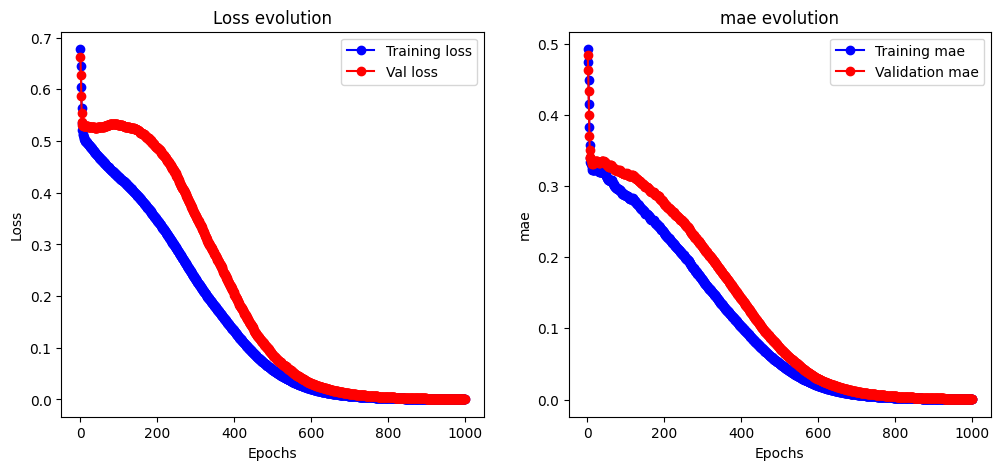

In [9]:
loss = history.history['loss']
val_loss = history.history['val_loss']

mae = history.history.get('mae')
val_mae = history.history.get('val_mae')

epochs = range(1, EPOCHS + 1)

plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo-', label = "Training loss")
plt.plot(epochs, val_loss, 'ro-', label = "Val loss")

plt.title("Loss evolution")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, mae, 'bo-', label='Training mae')
plt.plot(epochs, val_mae, 'ro-', label="Validation mae")
plt.title( "mae evolution")
plt.xlabel('Epochs')
plt.ylabel("mae")
plt.legend()
plt.show()

## Testing:

In [10]:

skateparks_list = [
    "Ahuntsic"         , # 0
    "VanHorne"         , # 1
    "Verdun"           , # 2
    "Lasalle"          , # 3
    "Préfontaine"      , # 4
    "Boucherville"     , # 5
    "Taz"              , # 6
    "Spin"             , # 7
    "Saint Jérome"     , # 8
    "Saint Sauveur"    , # 9
    "Assomption"       , # 10
    "Benny"            , # 11
    "Dorval"           , # 12
    "Magog"            , # 13
    "Berthierville"      # 14
]

# Weather: 
# Rain or Snow  = 0
# Clouds + Wind = 1
# Clouds        = 2
# Blue sky      = 3

weather_dict = {
    0: "Rain or Snow",
    1: "Windy or heavily cloudy",
    2: "cloudy",
    3: "Blue sky"
}

for idx_weather, weather_name in weather_dict.items():
    print("\n\n\n=== Weather:", weather_name, "===")
    for idx_skatespot, skatespot in enumerate(skateparks_list):

        result = model.predict([
            np.array([idx_skatespot]),   # index du skatepark
            np.array([idx_weather])    # weather
        ])
        print(f"Result for {skatespot} = {result[0][0] * 100} %")





=== Weather: Rain or Snow ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Result for Ahuntsic = 3.068374354597836e-08 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Result for VanHorne = 1.794597693919372e-15 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Result for Verdun = 1.5161270363009296e-16 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Result for Lasalle = 1.1840528557627295e-10 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Result for Préfontaine = 0.2163761705160141 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Result for Boucherville = 0.3888554275035858 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Result for Taz = 99.6633529663086 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Result for Spin = 99.66450500488281 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Result for Saint Jérome = 1.0190500526752189e-10 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Result for Saint Sauveur = 0.042860738933086395 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Result for Assomption = 0.0005931085324846208 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Result for B

## Convertion in tflite model:

In [11]:
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()

    with open("model.tflite", 'wb') as file:
        file.write(tflite_model)
    print("[+] Great success!!!!")
except Exception as e:
    print(f"[-] {e}")    

INFO:tensorflow:Assets written to: /tmp/tmpx8wz2vtw/assets


INFO:tensorflow:Assets written to: /tmp/tmpx8wz2vtw/assets


Saved artifact at '/tmp/tmpx8wz2vtw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 1), dtype=tf.float32, name='id_skateparks'), TensorSpec(shape=(None, 1), dtype=tf.float32, name='weather_input')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132047379130960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132047379132112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132047379132496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132047379133456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132047379132688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132047379133840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132047375941904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132047375942480: TensorSpec(shape=(), dtype=tf.resource, name=None)
[+] Great success!!!!


W0000 00:00:1764726063.272076   74457 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1764726063.272172   74457 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-12-03 01:41:03.275029: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpx8wz2vtw
2025-12-03 01:41:03.275577: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-03 01:41:03.275586: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpx8wz2vtw
I0000 00:00:1764726063.281159   74457 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-12-03 01:41:03.281778: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-03 01:41:03.309918: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpx8wz2vtw
2025-12-03 01:41:03.316827: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 